<a href="https://colab.research.google.com/github/Motunrayo244/EDISS-MP/blob/main/MachineLearning/MiniProject2/submitted_MiniProject2_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://raw.githubusercontent.com/Motunrayo244/EDISS-MP/main/MachineLearning/MiniProject2/Sentiment140.tenPercent.sample.tweets.tsv

0=negative
4= positive

In [ ]:
!pip uninstall accelerate transformers
!pip install accelerate transformers[torch]

#restart Your session on colab so the new transformer  is applied

Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.37.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? y
  Successfully uninstalled transformers-4.37.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 38.4 MB/s eta 0:00:00


In [ ]:
! wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
! unzip -q glove.twitter.27B.zip -d ./glovetwitter
# ! wget https://nlp.stanford.edu/data/glove.6B.zip
# ! unzip -q glove.6B.zip -d ./glove6B

--2024-02-24 13:59:08--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2024-02-24 13:59:08--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip.1’

glove.twitter.27B.z 100%[===================>]   1.42G  5.01MB/s    in 4m 45s  

2024-02-24 14:03:53 (5.09 MB/s) - ‘glove.twitter.27B.zip.1’ saved [1520408563/1520408563]

replace ./glovetwitter/glove.twitter.27B.25d.txt? [y]es, 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  seaborn as sns
import re
import string
import nltk
from numpy import array
from numpy import asarray
from numpy import zeros
from wordcloud import WordCloud, ImageColorGenerator
from time import perf_counter

from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from keras import losses,utils

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, Conv1D, LSTM, GlobalMaxPooling1D
from keras.layers import Embedding, TextVectorization
import graphviz
from keras.utils import plot_model

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,classification_report,confusion_matrix
from sklearn.metrics import roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score

from sklearn.metrics import ConfusionMatrixDisplay


from transformers import pipeline
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words =set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Motunrayo244/EDISS-MP/main/MachineLearning/MiniProject2/Sentiment140.tenPercent.sample.tweets.tsv',sep='\t')

In [ ]:
data.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [ ]:
data.shape

(160000, 2)

<Axes: ylabel='sentiment_label'>

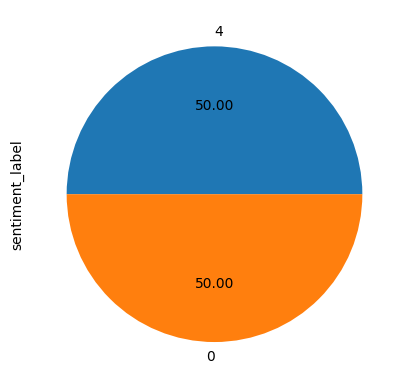

In [ ]:
data['sentiment_label'].value_counts().plot.pie(autopct='%.2f')

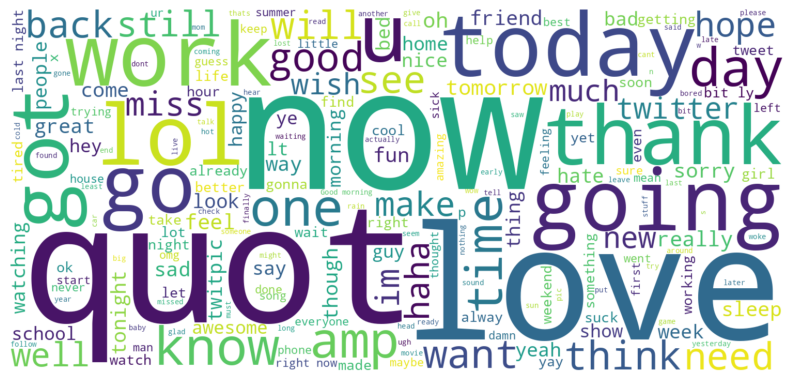

In [ ]:
text = " ".join(data['tweet_text'])

# Create a WordCloud object
wordcloud = WordCloud(width=1500, height=700, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Data Preprocessing

In [ ]:
def emoji_translator(text):
  emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
  for word in text:
    if word in emojis:
      text = text.replace(word, emojis[word])
  return text


In [ ]:
def basic_text_cleaner(text):
  ''' Make text lowercase, remove punctuations and usertags'''

    # Defining regex patterns.
  urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
  sequencePattern   =  r"(.)\1\1+"
  seqReplacePattern = r"\1 "
# '((@ \w*)|(@ \w*))'
  text = text.lower()
  text = re.sub('\@ \w+', '', text)
  text = re.sub('\@\w*', '', text)
  text = re.sub(urlPattern, '', text, flags=re.MULTILINE)
  text = emoji_translator(text)
  text = re.sub(sequencePattern, seqReplacePattern, text)
  text = re.sub('[^a-zA-Z0-9]', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ',text)
  text = re.sub('\d+', '',text)
  text = re.sub('\w\d\w*', '',text)
  text = re.sub(' +',' ',text)
  text_tokens = word_tokenize(text)
  filtered_text = [w for w in text_tokens if w not in stop_words]
  text = " ".join(filtered_text)

  return text

In [ ]:
data['cleaned_text'] = data['tweet_text'].apply(basic_text_cleaner)

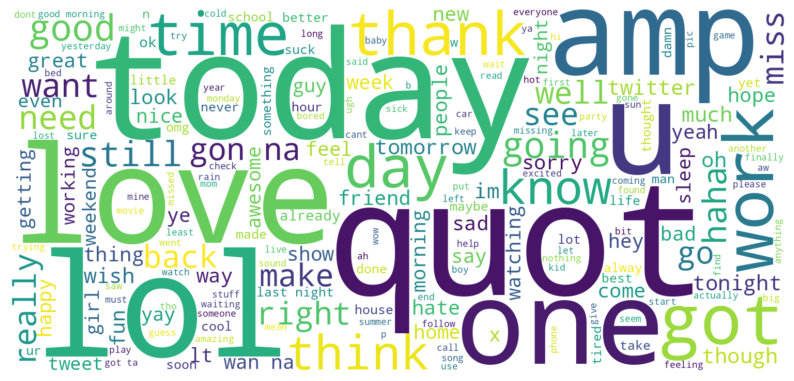

In [ ]:
text = " ".join(data['cleaned_text'])

# Create a WordCloud object
wordcloud = WordCloud(width=1500, height=700, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
data.head()

,sentiment_label,tweet_text,cleaned_text
0,4,"@elephantbird Hey dear, Happy Friday to You A...",hey dear happy friday already rice bowl lunch
1,4,Ughhh layin downnnn Waiting for zeina to co...,ugh layin waiting zeina cook breakfast
2,0,"@greeniebach I reckon he'll play, even if he's...",reckon play even know nothing without
3,0,@vaLewee I know! Saw it on the news!,know saw news
4,0,very sad that http://www.fabchannel.com/ has c...,sad closed one web services used years


### Machine Learning Models
In this section,
•	Random Forest classifier
•	Linear support Vector Machine
•	Multinomial Naïve Bayes
•	Logistic Regression

will be trained on the dataset and compared based on their Accuracy, F1_score, precision.



In [ ]:
data.shape

(160000, 3)

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vectors = vectorizer.fit_transform(data.cleaned_text)
vectorized_data = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
vectorized_data.head()

,able,absolutely,account,actually,add,afternoon,ago,agree,ah,ahead,...,yes,yesterday,yet,yo,young,youtube,yr,yum,yummy,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = vectorized_data.copy()
y = data.copy().sentiment_label.apply(lambda x: 1 if x ==4 else x )

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42, shuffle=True, stratify=y )

In [ ]:
def evaluate_models(clf,X_train, y_train, X_test, y_test):
  result = {}

  start = perf_counter ()
  train_pred = clf.predict(X_train)
  end = perf_counter()
  result['train_pred_time'] = end - start

  start = perf_counter ()
  test_pred = clf.predict(X_test)
  end = perf_counter()
  result['test_pred_time'] = end - start


  result['train_accuracy'] =  accuracy_score(y_true=y_train, y_pred= train_pred)
  result['train_f1'] =  f1_score(y_true=y_train, y_pred= train_pred)
  result['train_precision'] =  precision_score(y_true=y_train, y_pred= train_pred)
  result['train_recall'] =  precision_score(y_true=y_train, y_pred= train_pred)

  result['test_accuracy'] = accuracy_score(y_true=y_test, y_pred= test_pred)
  result['test_f1'] = f1_score(y_true=y_test, y_pred= test_pred)
  result['test_precision'] = precision_score (y_true=y_test, y_pred= test_pred)
  result['test_recall'] = recall_score(y_true=y_test, y_pred= test_pred)

  return result




In [ ]:
# cv = KFold(n_splits=3, random_state=42,shuffle=True)
clf_RF = RandomForestClassifier( n_estimators= 50,  random_state=42)
clf_SVC = LinearSVC()
clf_NB = MultinomialNB()
clf_LR = LogisticRegression(C=1e9, solver='lbfgs', max_iter=1000,random_state=42)

results = {}
models = [clf_RF,clf_SVC,clf_NB,clf_LR]
for clf in models:
  clf_name =  type(clf).__name__
  clf_result = {}
  start = perf_counter()
  clf.fit(X_train, y_train)
  end = perf_counter()
  clf_result['training_time'] = end - start
  clf_result.update(evaluate_models(clf,X_train[0:320000], y_train[0:320000], X_test, y_test))

  results[clf_name] = clf_result


In [ ]:
df_results = pd.DataFrame.from_dict(results)
df_results = df_results.transpose()

In [ ]:
df_results

,training_time,train_pred_time,test_pred_time,train_accuracy,train_f1,train_precision,train_recall,test_accuracy,test_f1,test_precision,test_recall
RandomForestClassifier,367.487507,19.079180,3.752349,0.953758,0.954770,0.934315,0.934315,0.727313,0.731326,0.720719,0.742250
LinearSVC,4.423613,0.195845,0.061873,0.743344,0.751907,0.727630,0.727630,0.736906,0.745257,0.722330,0.769687
MultinomialNB,0.387744,0.382758,0.094930,0.731023,0.727647,0.736898,0.736898,0.724906,0.720956,0.731459,0.710750
LogisticRegression,16.338791,0.225184,0.069759,0.743789,0.751431,0.729668,0.729668,0.737812,0.745186,0.724802,0.766750


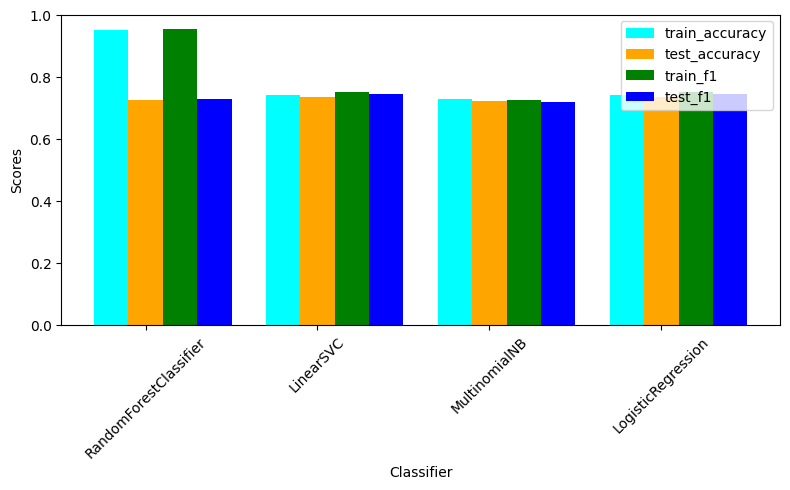

In [ ]:
plt.figure(figsize=(8, 5))
width = 0.2
x = np.arange(4)
# plot data in grouped manner of bar type
plt.bar(x-0.2, df_results['train_accuracy'],width, color='cyan')
plt.bar(x,df_results['test_accuracy'] , width, color='orange')
plt.bar(x+0.2, df_results['train_f1'], width, color='green')
plt.bar(x+0.4, df_results['test_f1'], width, color='blue')

plt.xticks(x, list(df_results.index))
plt.xlabel("Classifier")
plt.ylabel("Scores")
plt.legend(["train_accuracy", "test_accuracy", "train_f1", "test_f1"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
X_train.shape

(128000, 1000)

In [ ]:
def evaluate_model(model,X_test,y_test):
  pred = model.predict(X_test)

  accuracy = accuracy_score(y_true=y_test, y_pred= pred)
  f1 = f1_score(y_true=y_test, y_pred= pred)
  precision = precision_score (y_true=y_test, y_pred= pred)
  recall = recall_score(y_true=y_test, y_pred= pred)
  cm = confusion_matrix(y_true=y_test, y_pred=pred)

  total = np.sum(cm)

  cm = cm/total

  cm_display = ConfusionMatrixDisplay(cm).plot()
  print(f"{type(model).__name__}\n{classification_report(y_test, pred)}")

  return {'f1':f1,'acc':accuracy,'precision':precision,'recall':recall}

LogisticRegression
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      8000
           1       0.72      0.77      0.74      8000

    accuracy                           0.74     16000
   macro avg       0.74      0.74      0.74     16000
weighted avg       0.74      0.74      0.74     16000



{'f1': 0.7443919000848793,
 'acc': 0.7365,
 'precision': 0.722745467388745,
 'recall': 0.767375}

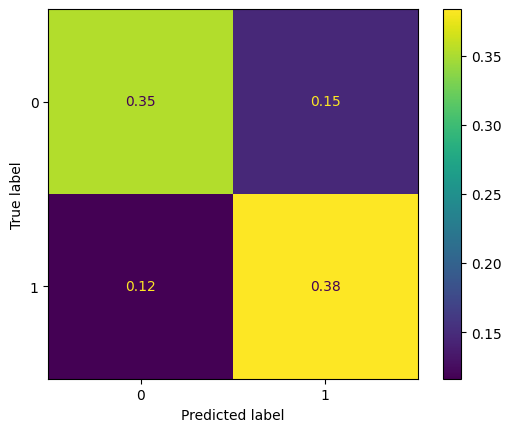

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1,random_state=42, shuffle=True, stratify=y )
LogisticRegression(C=1e9, solver='lbfgs', max_iter=1000,random_state=42)
clf.fit(X_train, y_train)
evaluate_model(model=clf, X_test= X_test, y_test=y_test)





In [ ]:
def plot_roc_pr(model, X_test, y_test):
    # Determine scores based on the availability of predict_proba or decision_function
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test)
    else:
        raise ValueError("Model does not have a predict_proba or a decision_function method.")

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

    # Calculate Precision-Recall curve
    prec, recall, _ = precision_recall_curve(y_test, y_score)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

    # Plot both ROC and Precision-Recall curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)

    ax1.set_title('ROC Curve')
    ax2.set_title('Precision-Recall Curve')
    plt.show()

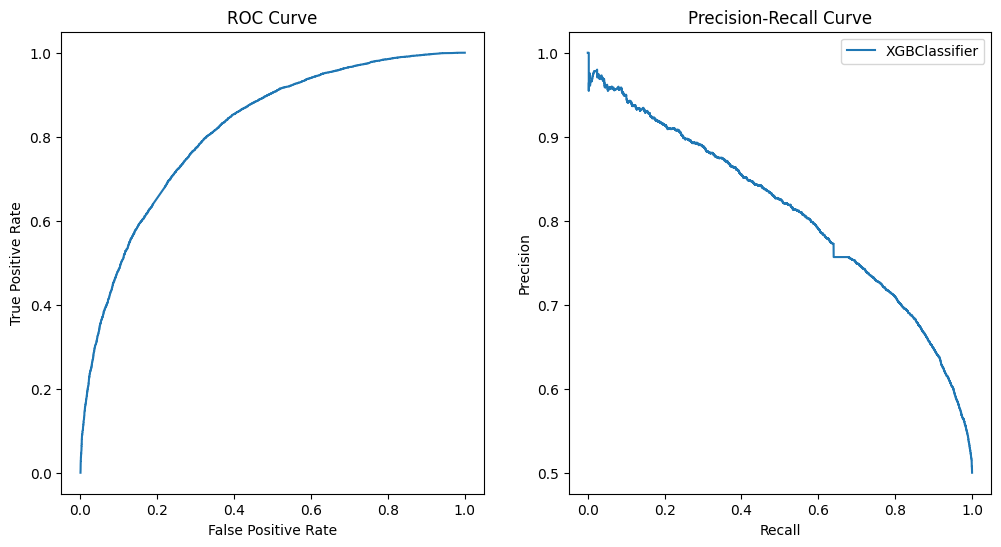

In [ ]:
evaluate_model(model=clf, X_test= X_test, y_test=y_test)
yclf_score = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_clf, tpr_clf, _ = roc_curve(y_test, yclf_score)
clf_roc_display = RocCurveDisplay(fpr=fpr_clf, tpr=tpr_clf)


# Calculate Precision-Recall curve
prec_clf, recall_clf, _ = precision_recall_curve(y_test, yclf_score)
clf_pr_display = PrecisionRecallDisplay(precision=prec_clf, recall=recall_clf)

# Plot both ROC and Precision-Recall curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
clf_roc_display.plot(ax=ax1)

clf_pr_display.plot(ax=ax2)


ax1.set_title('ROC Curve')
ax2.set_title('Precision-Recall Curve')
plt.legend(['XGBClassifier', 'GradientBoostingClassifier'])
plt.show()

### Deep Learning Models

In [ ]:
X = []
X = list(data['cleaned_text'])
y = data.copy().sentiment_label.apply(lambda x: 1 if x ==4 else x )

In [ ]:
X[4]

'sad closed one web services used years'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.8,random_state=42, shuffle=True, stratify=y )

In [ ]:
X = []
X = list(data['cleaned_text'])
y = data.copy().sentiment_label.apply(lambda x: 1 if x ==4 else x )
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1,random_state=42, shuffle=True, stratify=y )

In [ ]:
tokenizer = Tokenizer(num_words=800000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train[4]

[64, 56, 1019, 94, 18377, 18378, 573, 9187, 1, 5373]

In [ ]:
VOCAB_SIZE = len(tokenizer.word_index)+1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
embeddings_dictionary = dict()
# glove_file = open('glove6B/glove.6B.100d.txt', encoding="utf-8")
glove_file = open('glovetwitter/glove.twitter.27B.100d.txt', encoding="utf-8")
for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype ='float32')
  embeddings_dictionary[word] =vector_dimensions
glove_file.close()


In [ ]:
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, index in tokenizer.word_index.items():
  embedding_vector =embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
model = Sequential()
embedding_layer = Embedding(VOCAB_SIZE,100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Dense(units=16, activation="relu",
                ))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          5896500   
                                                                 
 dense (Dense)               (None, 100, 16)           1616      
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1601      
                                                                 
Total params: 5899717 (22.51 MB)
Trainable params: 3217 (12.57 KB)
Non-trainable params: 5896500 (22.49 MB)
_________________________________________________________________
None


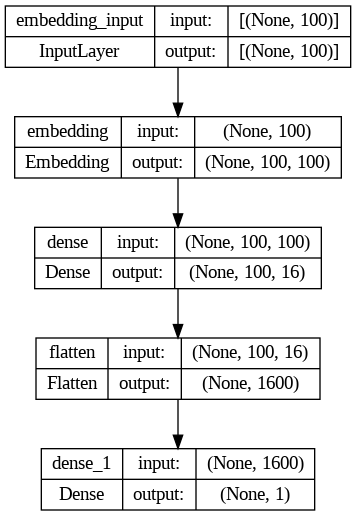

In [ ]:
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=11, verbose=1, validation_split=0.2)

Epoch 1/11
900/900 [==============================] - 7s 7ms/step - loss: 0.5604 - acc: 0.7132 - val_loss: 0.5323 - val_acc: 0.7352
Epoch 2/11
900/900 [==============================] - 5s 6ms/step - loss: 0.5270 - acc: 0.7416 - val_loss: 0.5231 - val_acc: 0.7458
Epoch 3/11
900/900 [==============================] - 6s 7ms/step - loss: 0.5195 - acc: 0.7472 - val_loss: 0.5181 - val_acc: 0.7501
Epoch 4/11
900/900 [==============================] - 6s 6ms/step - loss: 0.5144 - acc: 0.7514 - val_loss: 0.5144 - val_acc: 0.7510
Epoch 5/11
900/900 [==============================] - 7s 8ms/step - loss: 0.5100 - acc: 0.7542 - val_loss: 0.5126 - val_acc: 0.7527
Epoch 6/11
900/900 [==============================] - 6s 6ms/step - loss: 0.5077 - acc: 0.7562 - val_loss: 0.5153 - val_acc: 0.7531
Epoch 7/11
900/900 [==============================] - 6s 7ms/step - loss: 0.5051 - acc: 0.7574 - val_loss: 0.5096 - val_acc: 0.7544
Epoch 8/11
900/900 [==============================] - 5s 6ms/step - loss: 0.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

500/500 [==============================] - 2s 3ms/step - loss: 0.5179 - acc: 0.7499


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5178625583648682
Test Accuracy: 0.749875009059906


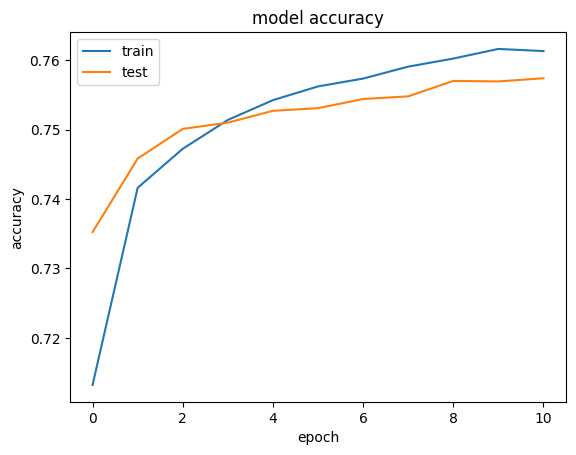

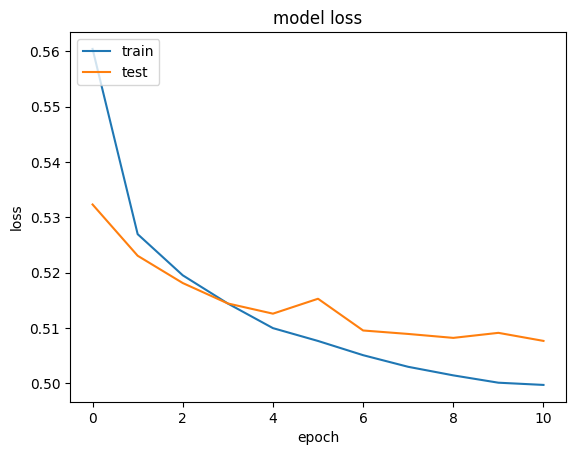

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

CNN

In [ ]:
model = Sequential()

embedding_layer = Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Dense(units=16, activation="relu", input_shape=(
100,)))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='ADAM', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          5896500   
                                                                 
 dense_5 (Dense)             (None, 100, 16)           1616      
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           10368     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5908613 (22.54 MB)
Trainable params: 12113 (47.32 KB)
Non-trainable params: 5896500 (22.49 MB)
___________

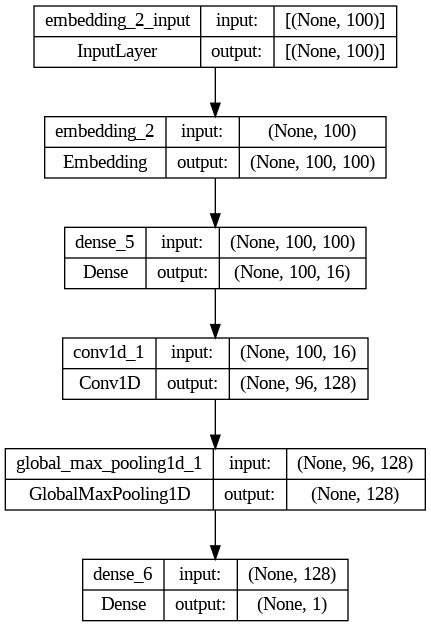

In [ ]:
utils.plot_model(model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/8
900/900 [==============================] - 19s 20ms/step - loss: 0.5259 - acc: 0.7320 - val_loss: 0.4945 - val_acc: 0.7567
Epoch 2/8
900/900 [==============================] - 17s 19ms/step - loss: 0.4929 - acc: 0.7581 - val_loss: 0.4882 - val_acc: 0.7596
Epoch 3/8
900/900 [==============================] - 16s 17ms/step - loss: 0.4836 - acc: 0.7647 - val_loss: 0.4837 - val_acc: 0.7627
Epoch 4/8
900/900 [==============================] - 17s 19ms/step - loss: 0.4764 - acc: 0.7694 - val_loss: 0.4815 - val_acc: 0.7644
Epoch 5/8
900/900 [==============================] - 15s 17ms/step - loss: 0.4701 - acc: 0.7731 - val_loss: 0.4817 - val_acc: 0.7651
Epoch 6/8
900/900 [==============================] - 16s 18ms/step - loss: 0.4647 - acc: 0.7773 - val_loss: 0.4827 - val_acc: 0.7638
Epoch 7/8
900/900 [==============================] - 15s 17ms/step - loss: 0.4599 - acc: 0.7799 - val_loss: 0.4837 - val_acc: 0.7653
Epoch 8/8
500/500 [==============================] - 2s 4ms/step - lo

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.49948686361312866
Test Accuracy: 0.7539374828338623


ROC and Precision recall curve of Logistic Regression

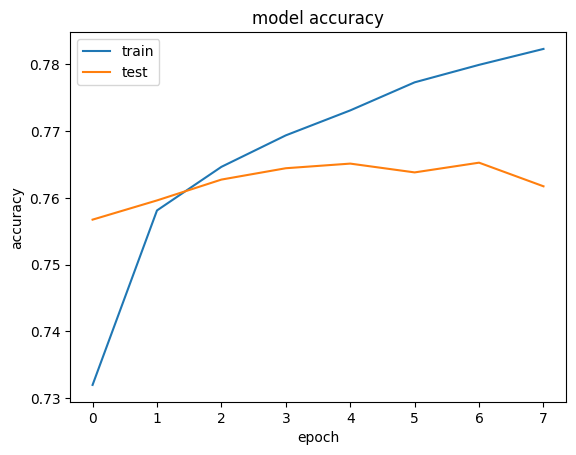

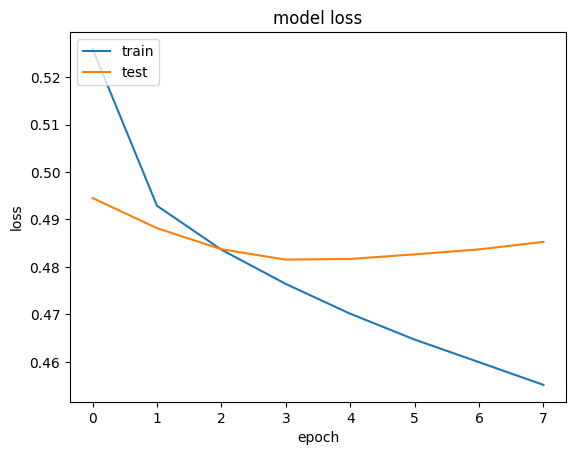

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### Transfer Learning
Disclaimer: Run this part if you have access to a GPU. Also ensure that you restarted the colab session after reinstalling transformer. If you do not restart the colab, a cell in the code will fail with an error requesing for Accelerator.

Transfer learning is a technique that enhances the performance of learners in specific domains by leveraging knowledge from different, yet related, source domains. This approach decreases the reliance on extensive data from the target domain for developing learners.

DistilBERT is a streamlined version of the BERT model (a transformer model), designed to be smaller and more efficient. It was trained on the same data set using a method of self-supervision, with the original BERT model serving as its guide.

We will be using the distilbert-base-uncased model from hugging face

In [ ]:
model_name="distilbert-base-uncased"
model =AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
X = []
X = list(data['tweet_text'])
y = data.copy().sentiment_label.apply(lambda x: 1 if x ==4 else x )
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42, shuffle=True, stratify=y )
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25,random_state=42, shuffle=True, stratify=y_train )

In [ ]:
from torch.utils.data import Dataset
'''create a class for te dataset'''

class TwitterDataset(Dataset):
  def __init__ (self, encoding,labels):
    self.encodings = encoding
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)





In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

train_encoding = tokenizer(X_train, truncation= True, padding=True)
val_encoding = tokenizer(X_val, truncation= True, padding=True)
test_encoding = tokenizer(X_test, truncation= True, padding=True)

In [ ]:
train_dataset = TwitterDataset(train_encoding, list(y_train))
val_dataset = TwitterDataset(val_encoding, list(y_val))
test_dataset = TwitterDataset(test_encoding, list(y_test))

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained(model_name)
model.to(device)
optim = AdamW(model.parameters(), lr=2e-5)
# model.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def evaluate(model, val_loader, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            val_loss += outputs.loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            predictions.extend(preds.tolist())
            true_labels.extend(labels.tolist())

    accuracy = correct / total
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return val_loss / len(val_loader), accuracy, precision, recall,f1


In [ ]:
# Training loop with evaluation and checkpointing
best_val_accuracy = 0.0
best_f1 =0.0
model_save_path = 'best_model_state.bin'
num_train_epochs = 2

for epoch in range(num_train_epochs):
    model.train()
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

    val_loss, val_accuracy, val_precision, val_recall, val_f1,  = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val precision: {val_precision:.4f},Val recall: {val_recall:.4f}, Val F1 Score: {val_f1:.4f}")

    # Checkpointing
    if val_accuracy > best_val_accuracy and val_f1 > best_f1:
        best_val_accuracy = val_accuracy
        best_f1 = val_f1
        torch.save(model.state_dict(), model_save_path)
        print(f"New best model saved with accuracy: {val_accuracy:.4f} and f1 {val_f1:.4f}")


Epoch 1, Val Loss: 0.4174, Val Accuracy: 0.8340, Val precision: 0.8468,Val recall: 0.8155, Val F1 Score: 0.8309
New best model saved with accuracy: 0.8340 and f1 0.8309
Epoch 2, Val Loss: 0.4874, Val Accuracy: 0.8282, Val precision: 0.8560,Val recall: 0.7893, Val F1 Score: 0.8213


In [ ]:
# Load best model for prediction
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Prediction on test set
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        test_predictions.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

In [ ]:
def evaluate_bert_model(test_labels, test_predictions):
  accuracy = accuracy_score(y_true=test_labels, y_pred= test_predictions)
  f1 = f1_score(y_true=test_labels, y_pred= test_predictions)
  precision = precision_score (y_true=test_labels, y_pred= test_predictions)
  recall = recall_score(y_true=test_labels, y_pred= test_predictions)
  cm = confusion_matrix(y_true=test_labels, y_pred= test_predictions)

  cm_display = ConfusionMatrixDisplay(cm).plot()
  print(f"{type(model).__name__}\n{classification_report(test_labels, test_predictions)}")

  return {'f1':f1,'acc':accuracy,'precision':precision,'recall':recall}

DistilBertForSequenceClassification
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     16000
           1       0.86      0.82      0.84     16000

    accuracy                           0.84     32000
   macro avg       0.84      0.84      0.84     32000
weighted avg       0.84      0.84      0.84     32000



{'f1': 0.8356615414122687,
 'acc': 0.83934375,
 'precision': 0.8552640188444677,
 'recall': 0.8169375}

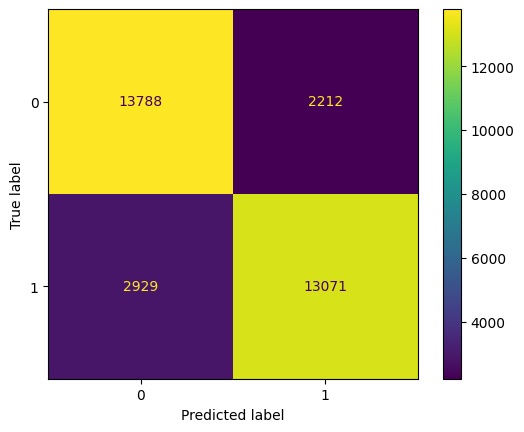

In [ ]:
evaluate_bert_model(test_labels, test_predictions)

In [ ]:
# Calculate performance metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score (test_labels, test_predictions)
test_recall =recall_score (test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.8356, Test F1 Score: 0.8319
